# Create a master frame for plotting anything with seaborn.
Create a file `worm_data_master.csv` that aggregates worm data from all datasets.

In [188]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from utils import VALID_DATASETS
from data._utils import load_dataset

In [29]:
all_worm_datasets = [
    load_dataset(dataset)
    for dataset in sorted(VALID_DATASETS, key=lambda x: x[-4:])
    if not dataset.__contains__("sine")
]

In [30]:
new_dict = dict()

for dataset in all_worm_datasets:
    for worm in dataset:
        for neuron, slot in dataset[worm]["neuron_to_slot"].items():
            # get data to fill in table
            dataset_name = dataset[worm]["dataset"]
            smooth_method = dataset[worm]["smooth_method"]
            calcium_data = dataset[worm]["calcium_data"][:, slot].numpy()
            smooth_calcium_data = dataset[worm]["smooth_calcium_data"][:, slot].numpy()
            residual_calcium = dataset[worm]["residual_calcium"][:, slot].numpy()
            smooth_residual_calcium = dataset[worm]["smooth_residual_calcium"][
                :, slot
            ].numpy()
            time_in_seconds = dataset[worm]["time_in_seconds"].squeeze().numpy()
            dt = dataset[worm]["dt"].squeeze().numpy()
            max_timesteps = dataset[worm]["max_timesteps"]
            if neuron in dataset[worm]["named_neuron_to_slot"]:
                is_named_neuron = True
                is_unknown_neuron = False
            elif neuron in dataset[worm]["unknown_neuron_to_slot"]:
                is_named_neuron = False
                is_unknown_neuron = True
            else:
                print("Neither named nor unknown neuron?!?!?!")

            # fill in table
            new_dict.setdefault("dataset", new_dict.get("dataset", [])).append(
                dataset_name
            )
            new_dict.setdefault("worm", new_dict.get("worm", [])).append(worm)
            new_dict.setdefault("neuron", new_dict.get("neuron", [])).append(neuron)
            new_dict.setdefault("slot", new_dict.get("slot", [])).append(slot)
            new_dict.setdefault(
                "is_named_neuron", new_dict.get("is_named_neuron", [])
            ).append(is_named_neuron)
            new_dict.setdefault(
                "is_unknown_neuron", new_dict.get("is_unknown_neuron", [])
            ).append(is_unknown_neuron)
            new_dict.setdefault(
                "calcium_data", new_dict.get("calcium_data", [])
            ).append(calcium_data)
            new_dict.setdefault(
                "smooth_calcium_data", new_dict.get("smooth_calcium_data", [])
            ).append(smooth_calcium_data)
            new_dict.setdefault(
                "residual_calcium", new_dict.get("residual_calcium", [])
            ).append(residual_calcium)
            new_dict.setdefault(
                "smooth_residual_calcium", new_dict.get("smooth_residual_calcium", [])
            ).append(smooth_residual_calcium)
            new_dict.setdefault(
                "smooth_method", new_dict.get("smooth_method", [])
            ).append(smooth_method)
            new_dict.setdefault(
                "time_in_seconds", new_dict.get("time_in_seconds", [])
            ).append(time_in_seconds)
            new_dict.setdefault("dt", new_dict.get("dt", [])).append(dt)
            new_dict.setdefault(
                "max_timesteps", new_dict.get("max_timesteps", [])
            ).append(max_timesteps)

In [31]:
df = pd.DataFrame.from_dict(new_dict)

In [ ]:
df.head()

,dataset,worm,neuron,slot,is_named_neuron,is_unknown_neuron,calcium_data,smooth_calcium_data,residual_calcium,smooth_residual_calcium,smooth_method,time_in_seconds,dt,max_timesteps
0,Kato2015,worm0,ADAL,0,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FFT,"[0.0, 0.32757053, 0.65514106, 0.98271155, 1.31...","[0.0, 0.32757053, 0.32757053, 0.3275705, 0.327...",2198
1,Kato2015,worm0,19,1,False,True,"[1.0, 0.55727464, 0.8784727, 0.54866844, 0.417...","[0.06549119, 0.19379899, 0.3128095, 0.41858488...","[0.0, -0.44272536, 0.32119805, -0.32980424, -0...","[0.0, 0.12830779, 0.11901051, 0.105775386, 0.0...",FFT,"[0.0, 0.32757053, 0.65514106, 0.98271155, 1.31...","[0.0, 0.32757053, 0.32757053, 0.3275705, 0.327...",2198
2,Kato2015,worm0,ADEL,2,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FFT,"[0.0, 0.32757053, 0.65514106, 0.98271155, 1.31...","[0.0, 0.32757053, 0.32757053, 0.3275705, 0.327...",2198
3,Kato2015,worm0,ADER,3,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FFT,"[0.0, 0.32757053, 0.65514106, 0.98271155, 1.31...","[0.0, 0.32757053, 0.32757053, 0.3275705, 0.327...",2198
4,Kato2015,worm0,ADFL,4,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FFT,"[0.0, 0.32757053, 0.65514106, 0.98271155, 1.31...","[0.0, 0.32757053, 0.32757053, 0.3275705, 0.327...",2198


In [ ]:
df.tail()

,dataset,worm,neuron,slot,is_named_neuron,is_unknown_neuron,calcium_data,smooth_calcium_data,residual_calcium,smooth_residual_calcium,smooth_method,time_in_seconds,dt,max_timesteps
46503,Leifer2023,worm47,VD5,297,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FFT,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",830
46504,Leifer2023,worm47,VD6,298,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FFT,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",830
46505,Leifer2023,worm47,376,299,False,True,"[-0.5264574, -0.5177983, -0.4251063, -0.579548...","[-0.50199616, -0.446988, -0.39259207, -0.34075...","[0.0, 0.008659124, 0.09269202, -0.15444231, -0...","[0.0, 0.055008173, 0.054395914, 0.051840574, 0...",FFT,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",830
46506,Leifer2023,worm47,388,300,False,True,"[-0.22970566, -0.25295773, -0.3870431, -0.0094...","[-0.12946372, -0.023043308, 0.07762321, 0.1692...","[0.0, -0.02325207, -0.13408536, 0.37762284, -0...","[0.0, 0.10642041, 0.10066652, 0.09163741, 0.07...",FFT,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",830
46507,Leifer2023,worm47,356,301,False,True,"[-0.46128872, -0.46736977, -0.52808785, -0.759...","[-0.5091446, -0.4529641, -0.3935889, -0.333974...","[0.0, -0.0060810447, -0.06071809, -0.23130208,...","[0.0, 0.056180507, 0.059375197, 0.05961451, 0....",FFT,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",830


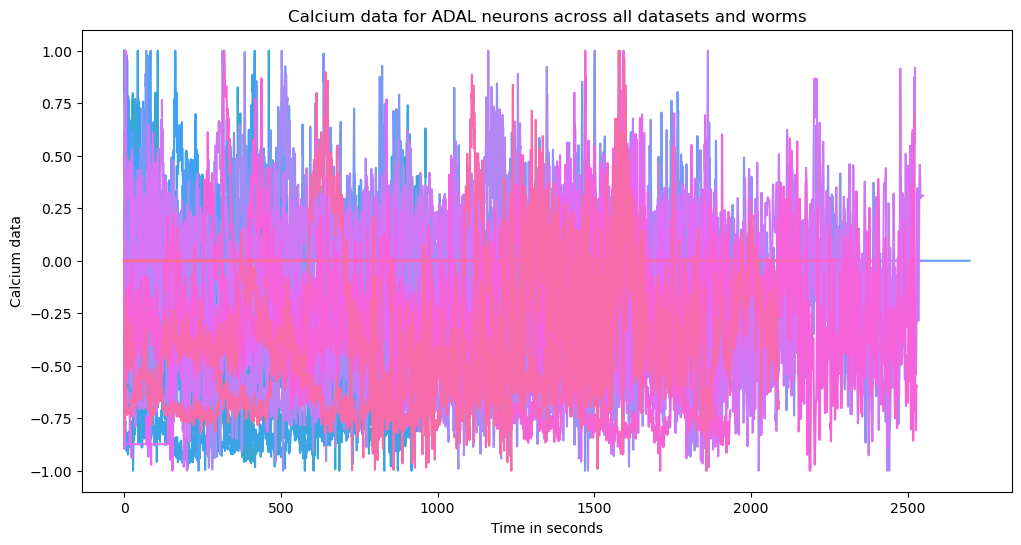

In [181]:
# Assuming your DataFrame is called 'df'
adal_neurons = df[df["neuron"] == "ADAL"]

# Create a new DataFrame to store calcium data and time_in_seconds for each "ADAL" neuron
calcium_time_data_adal = pd.DataFrame()

for idx, neuron in adal_neurons.iterrows():
    temp_df = pd.DataFrame(
        {
            "time_in_seconds": neuron["time_in_seconds"],
            "calcium_data": neuron["calcium_data"],
            "worm": f"worm{idx}",
        }
    )
    calcium_time_data_adal = pd.concat([calcium_time_data_adal, temp_df])

# Use seaborn to create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=calcium_time_data_adal,
    x="time_in_seconds",
    y="calcium_data",
    hue="worm",
    legend=False,
)

plt.xlabel("Time in seconds")
plt.ylabel("Calcium data")
plt.title("Calcium data for ADAL neurons across all datasets and worms")

plt.show()

In [182]:
calcium_time_data_adal

,time_in_seconds,calcium_data,worm
0,0.000000,0.0,worm0
1,0.327571,0.0,worm0
2,0.655141,0.0,worm0
3,0.982712,0.0,worm0
4,1.310282,0.0,worm0
...,...,...,...
825,412.500000,0.0,worm46206
826,413.000000,0.0,worm46206
827,413.500000,0.0,worm46206
828,414.000000,0.0,worm46206


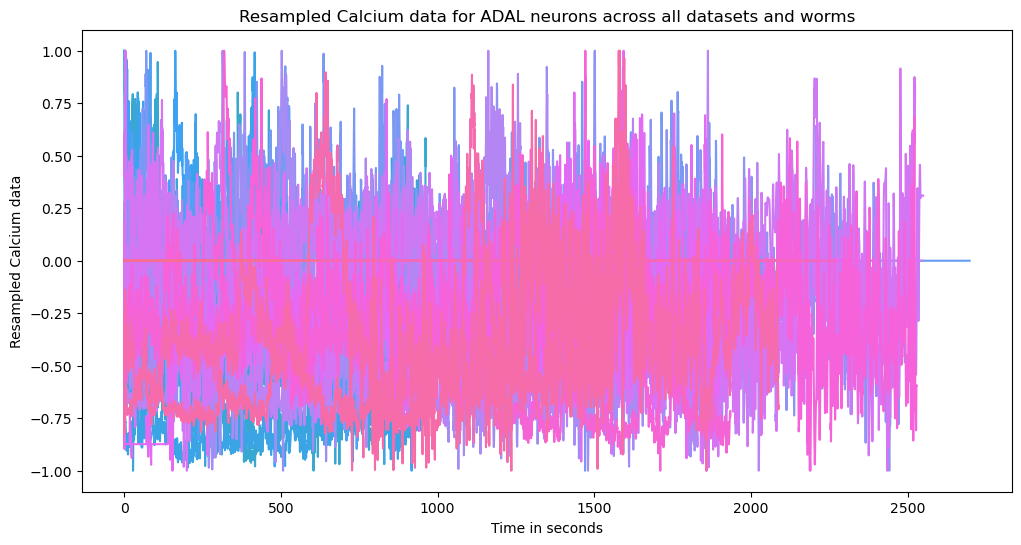

In [200]:
DT = 0.25


def interpolate_data(time, data, target_frequency=DT):
    target_time = np.arange(time.min(), time.max(), target_frequency)
    interpolated_data = np.interp(target_time, time, data)
    return target_time, interpolated_data


# Create a new DataFrame to store resampled calcium data and time_in_seconds for each "ADAL" neuron
resampled_calcium_time_data_adal = pd.DataFrame()

for idx, neuron in adal_neurons.iterrows():
    # Interpolate the calcium_data and time_in_seconds
    new_time, new_data = interpolate_data(
        np.array(neuron["time_in_seconds"]),
        np.array(neuron["calcium_data"]),
    )

    temp_df = pd.DataFrame(
        {"time_in_seconds": new_time, "calcium_data": new_data, "worm": f"worm{idx}"}
    )
    resampled_calcium_time_data_adal = pd.concat(
        [resampled_calcium_time_data_adal, temp_df]
    )

# Use seaborn to create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=resampled_calcium_time_data_adal,
    x="time_in_seconds",
    y="calcium_data",
    hue="worm",
    legend=False,
)

plt.xlabel("Time in seconds")
plt.ylabel("Resampled Calcium data")
plt.title("Resampled Calcium data for ADAL neurons across all datasets and worms")

plt.show()

In [201]:
resampled_calcium_time_data_adal

,time_in_seconds,calcium_data,worm
0,0.00,0.0,worm0
1,0.25,0.0,worm0
2,0.50,0.0,worm0
3,0.75,0.0,worm0
4,1.00,0.0,worm0
...,...,...,...
1653,413.25,0.0,worm46206
1654,413.50,0.0,worm46206
1655,413.75,0.0,worm46206
1656,414.00,0.0,worm46206


In [202]:
def plot_frequency_distribution(data, ax, title, dt=DT):
    # Compute the FFT and frequencies
    fft_data = torch.fft.rfft(torch.tensor(data))
    freqs = torch.fft.rfftfreq(len(data), d=dt)

    # Plot the frequency distribution
    ax.plot(freqs, torch.abs(fft_data))
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)

In [203]:
# Define a function to calculate the confidence interval
def bootstrap_ci(data, num_bootstraps=1000, alpha=0.05):
    bootstrapped_means = np.empty(num_bootstraps)
    for i in range(num_bootstraps):
        resampled_data = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means[i] = np.mean(resampled_data)
    lower_bound = np.percentile(bootstrapped_means, alpha * 100 / 2)
    upper_bound = np.percentile(bootstrapped_means, 100 - alpha * 100 / 2)
    return lower_bound, upper_bound

In [204]:
# Filter out worms with zero calcium data
nonzero_adal_worms = calcium_time_data_adal.groupby("worm").filter(
    lambda x: not np.all(x["calcium_data"] == 0)
)

unique_worms = nonzero_adal_worms["worm"].unique()

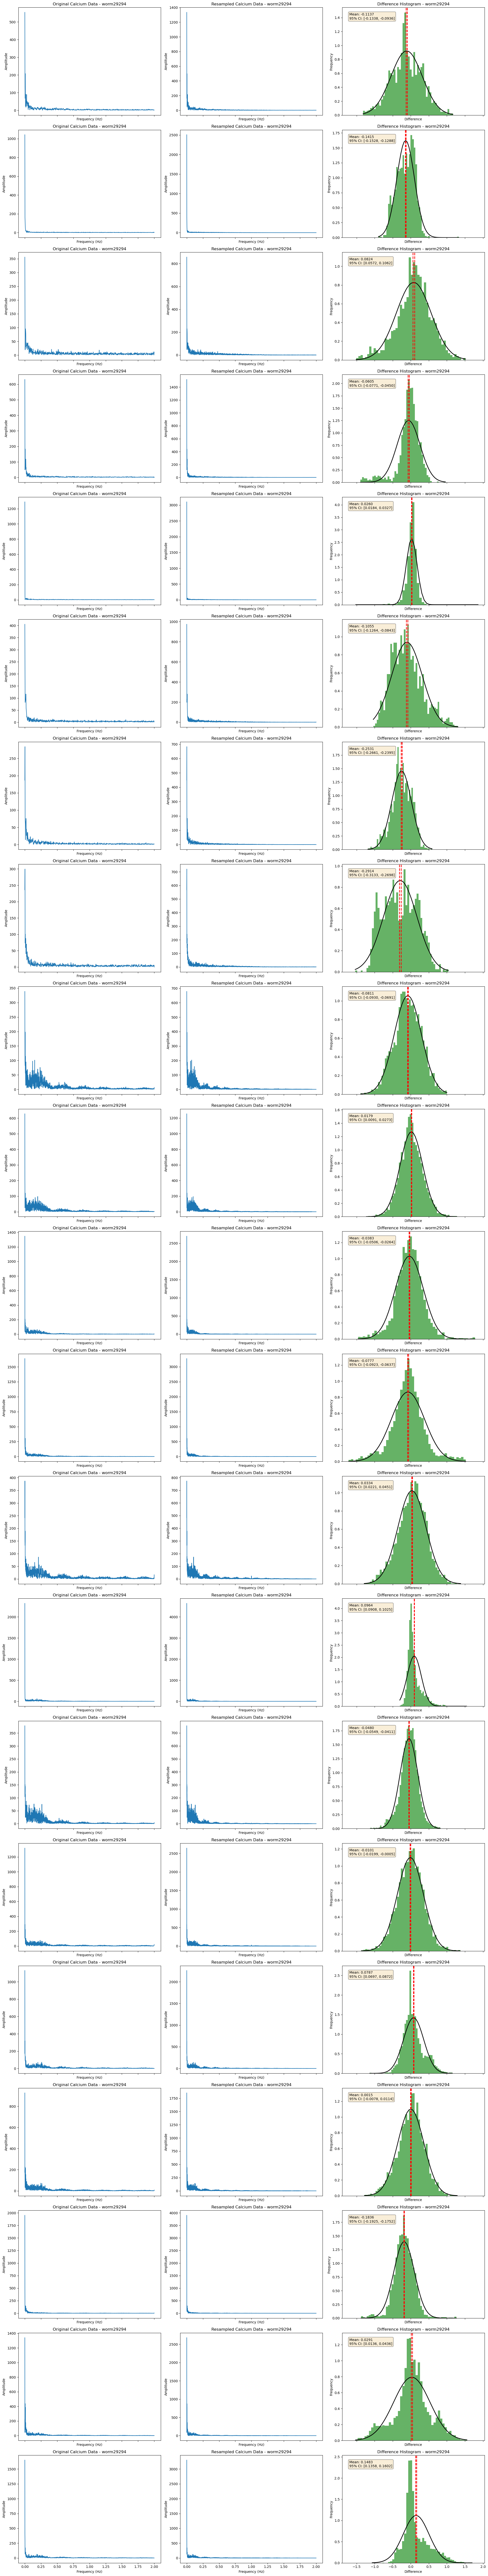

In [205]:
fig, axes = plt.subplots(
    nrows=len(unique_worms), ncols=3, figsize=(20, 5 * len(unique_worms)), sharex="col"
)

for index, worm_id in enumerate(unique_worms):
    # Select the original calcium_data for the current worm
    original_data = nonzero_adal_worms[nonzero_adal_worms.worm == worm_id][
        "calcium_data"
    ]

    # Select the resampled calcium_data for the current worm
    resampled_data = resampled_calcium_time_data_adal[
        resampled_calcium_time_data_adal.worm == worm_id
    ]["calcium_data"]

    if len(original_data) == 0 or len(resampled_data) == 0:
        continue

    # Compute the difference between original and resampled calcium_data
    difference = original_data - resampled_data
    difference = difference.dropna()

    # Plot the frequency distribution of the original calcium_data
    plot_frequency_distribution(
        original_data, axes[index, 0], f"Original Calcium Data - {worm}"
    )

    # Plot the frequency distribution of the resampled calcium_data
    plot_frequency_distribution(
        resampled_data, axes[index, 1], f"Resampled Calcium Data - {worm}"
    )

    # Plot the histogram of the difference
    n, bins, patches = axes[index, 2].hist(
        difference, bins=50, density=True, alpha=0.6, color="g"
    )

    # Fit a normal distribution to the difference
    mu, std = stats.norm.fit(difference)
    epsilon = 1e-8
    p = stats.norm.pdf(bins, mu, std + epsilon)
    axes[index, 2].plot(bins, p, "k", linewidth=2)

    # Compute the bootstrap 95% confidence interval for the mean of the difference
    ci_lower, ci_upper = bootstrap_ci(difference)

    # Add the confidence interval to the plot
    axes[index, 2].axvline(ci_lower, color="red", linestyle="dashed", linewidth=2)
    axes[index, 2].axvline(ci_upper, color="red", linestyle="dashed", linewidth=2)

    axes[index, 2].set_title(f"Difference Histogram - {worm}")
    axes[index, 2].set_xlabel("Difference")
    axes[index, 2].set_ylabel("Frequency")

    # Add the mean and confidence interval as an annotation
    mean_text = f"Mean: {mu:.4f}"
    ci_text = f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]"
    axes[index, 2].text(
        0.05,
        0.95,
        f"{mean_text}\n{ci_text}",
        transform=axes[index, 2].transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
    )

plt.tight_layout()
plt.show()

In [ ]:
# pd.DataFrame.to_csv(df, "../data/worm_data_short.csv")

We want to convert to a Multi-index DataFrame.

In [ ]:
index = pd.MultiIndex.from_frame(
    df[
        [
            "dataset",
            "worm",
            "neuron",
            # "slot",
            # "is_named_neuron",
            # "smooth_method",
            # "max_timesteps",
        ]
    ]
)
index

MultiIndex([(  'Kato2015',  'worm0', 'ADAL'),
            (  'Kato2015',  'worm0',   '19'),
            (  'Kato2015',  'worm0', 'ADEL'),
            (  'Kato2015',  'worm0', 'ADER'),
            (  'Kato2015',  'worm0', 'ADFL'),
            (  'Kato2015',  'worm0', 'ADFR'),
            (  'Kato2015',  'worm0', 'ADLL'),
            (  'Kato2015',  'worm0', 'ADLR'),
            (  'Kato2015',  'worm0', 'AFDL'),
            (  'Kato2015',  'worm0', 'AFDR'),
            ...
            ('Leifer2023', 'worm47', 'VD12'),
            ('Leifer2023', 'worm47', 'VD13'),
            ('Leifer2023', 'worm47',  'VD2'),
            ('Leifer2023', 'worm47',  '365'),
            ('Leifer2023', 'worm47',  'VD4'),
            ('Leifer2023', 'worm47',  'VD5'),
            ('Leifer2023', 'worm47',  'VD6'),
            ('Leifer2023', 'worm47',  '376'),
            ('Leifer2023', 'worm47',  '388'),
            ('Leifer2023', 'worm47',  '356')],
           names=['dataset', 'worm', 'neuron'], length=46508)

In [ ]:
master_dict = dict()
for idx in df.index:
    columns = [
        "time_in_seconds",
        "dt",
        "calcium_data",
        "smooth_calcium_data",
        "residual_calcium",
        "smooth_residual_calcium",
    ]
    for col in columns:
        key = index[idx] + (col,)
        data = pd.Series(df.iloc[idx][col], dtype=np.float16)
        master_dict[key] = data

In [ ]:
arrays = list(zip(*master_dict.keys()))
new_index = pd.MultiIndex.from_arrays(
    arrays,
    names=[
        "dataset",
        "worm",
        "neuron",
        # "slot",
        # "is_named_neuron",
        # "smooth_method",
        # "max_timesteps",
        "time_series",
    ],
)
new_index

MultiIndex([(  'Kato2015',  'worm0', 'ADAL',         'time_in_seconds'),
            (  'Kato2015',  'worm0', 'ADAL',                      'dt'),
            (  'Kato2015',  'worm0', 'ADAL',            'calcium_data'),
            (  'Kato2015',  'worm0', 'ADAL',     'smooth_calcium_data'),
            (  'Kato2015',  'worm0', 'ADAL',        'residual_calcium'),
            (  'Kato2015',  'worm0', 'ADAL', 'smooth_residual_calcium'),
            (  'Kato2015',  'worm0',   '19',         'time_in_seconds'),
            (  'Kato2015',  'worm0',   '19',                      'dt'),
            (  'Kato2015',  'worm0',   '19',            'calcium_data'),
            (  'Kato2015',  'worm0',   '19',     'smooth_calcium_data'),
            ...
            ('Leifer2023', 'worm47',  '388',            'calcium_data'),
            ('Leifer2023', 'worm47',  '388',     'smooth_calcium_data'),
            ('Leifer2023', 'worm47',  '388',        'residual_calcium'),
            ('Leifer2023', 'worm47'

In [ ]:
new_df = pd.DataFrame(master_dict.values(), index=new_index).sort_index()

In [ ]:
new_df.head()

0         1     \
dataset     worm  neuron time_series                                   
Flavell2023 worm0 105    calcium_data            -0.077087 -0.189209   
                         dt                       0.000000  0.641602   
                         residual_calcium         0.000000 -0.112183   
                         smooth_calcium_data     -0.542480 -0.509766   
                         smooth_residual_calcium  0.000000  0.032745   

                                                      2         3     \
dataset     worm  neuron time_series                                   
Flavell2023 worm0 105    calcium_data            -0.314209 -0.364502   
                         dt                       0.600098  0.600098   
                         residual_calcium        -0.125000 -0.050140   
                         smooth_calcium_data     -0.485352 -0.470459   
                         smooth_residual_calcium  0.024414  0.014786   

                                                      4         5     \
dataset     worm  neuron time_series                                   
Flavell2023 worm0 105    calcium_data            -0.488525 -0.530762   
                         dt                       0.599609  0.625000   
                         residual_calcium        -0.124146 -0.042389   
                         smooth_calcium_data     -0.466064 -0.471924   
                         smooth_residual_calcium  0.004478 -0.005890   

                                                      6         7     \
dataset     worm  neuron time_series                                   
Flavell2023 worm0 105    calcium_data            -0.562988 -0.587402   
                         dt                       0.552734  0.637695   
                         residual_calcium        -0.031860 -0.024826   
                         smooth_calcium_data     -0.487549 -0.511719   
                         smooth_residual_calcium -0.015686 -0.024353   

                                                      8         9     ...  \
dataset     worm  neuron time_series                                  ...   
Flavell2023 worm0 105    calcium_data            -0.630859 -0.661621  ...   
                         dt                       0.584961  0.600098  ...   
                         residual_calcium        -0.043274 -0.030670  ...   
                         smooth_calcium_data     -0.543457 -0.579590  ...   
                         smooth_residual_calcium -0.031372 -0.036438  ...   

                                                  5445  5446  5447  5448  \
dataset     worm  neuron time_series                                       
Flavell2023 worm0 105    calcium_data              NaN   NaN   NaN   NaN   
                         dt                        NaN   NaN   NaN   NaN   
                         residual_calcium          NaN   NaN   NaN   NaN   
                         smooth_calcium_data       NaN   NaN   NaN   NaN   
                         smooth_residual_calcium   NaN   NaN   NaN   NaN   

                                                  5449  5450  5451  5452  \
dataset     worm  neuron time_series                                       
Flavell2023 worm0 105    calcium_data              NaN   NaN   NaN   NaN   
                         dt                        NaN   NaN   NaN   NaN   
                         residual_calcium          NaN   NaN   NaN   NaN   
                         smooth_calcium_data       NaN   NaN   NaN   NaN   
                         smooth_residual_calcium   NaN   NaN   NaN   NaN   

                                                  5453  5454  
dataset     worm  neuron time_series                          
Flavell2023 worm0 105    calcium_data              NaN   NaN  
                         dt                        NaN   NaN  
                         residual_calcium          NaN   NaN  
                         smooth_calcium_data       NaN   NaN  
                         smooth_residual_calcium  

In [ ]:
new_df.tail()

0         1         2     \
dataset  worm  neuron time_series                                         
Uzel2022 worm5 VD9    dt                        0.0  0.326172  0.326172   
                      residual_calcium          0.0  0.000000  0.000000   
                      smooth_calcium_data       0.0  0.000000  0.000000   
                      smooth_residual_calcium   0.0  0.000000  0.000000   
                      time_in_seconds           0.0  0.326172  0.652344   

                                                   3         4         5     \
dataset  worm  neuron time_series                                             
Uzel2022 worm5 VD9    dt                       0.326172  0.326172  0.326172   
                      residual_calcium         0.000000  0.000000  0.000000   
                      smooth_calcium_data      0.000000  0.000000  0.000000   
                      smooth_residual_calcium  0.000000  0.000000  0.000000   
                      time_in_seconds          0.978516  1.304688  1.630859   

                                                   6         7         8     \
dataset  worm  neuron time_series                                             
Uzel2022 worm5 VD9    dt                       0.326172  0.326172  0.326172   
                      residual_calcium         0.000000  0.000000  0.000000   
                      smooth_calcium_data      0.000000  0.000000  0.000000   
                      smooth_residual_calcium  0.000000  0.000000  0.000000   
                      time_in_seconds          1.957031  2.283203  2.609375   

                                                   9     ...  5445  5446  \
dataset  worm  neuron time_series                        ...               
Uzel2022 worm5 VD9    dt                       0.326172  ...   NaN   NaN   
                      residual_calcium         0.000000  ...   NaN   NaN   
                      smooth_calcium_data      0.000000  ...   NaN   NaN   
                      smooth_residual_calcium  0.000000  ...   NaN   NaN   
                      time_in_seconds          2.935547  ...   NaN   NaN   

                                               5447  5448  5449  5450  5451  \
dataset  worm  neuron time_series                                             
Uzel2022 worm5 VD9    dt                        NaN   NaN   NaN   NaN   NaN   
                      residual_calcium          NaN   NaN   NaN   NaN   NaN   
                      smooth_calcium_data       NaN   NaN   NaN   NaN   NaN   
                      smooth_residual_calcium   NaN   NaN   NaN   NaN   NaN   
                      time_in_seconds           NaN   NaN   NaN   NaN   NaN   

                                               5452  5453  5454  
dataset  worm  neuron time_series                                
Uzel2022 worm5 VD9    dt                        NaN   NaN   NaN  
                      residual_calcium          NaN   NaN   NaN  
                      smooth_calcium_data       NaN   NaN   NaN  
                      smooth_residual_calcium   NaN   NaN   NaN  
                      time_in_seconds           NaN   NaN   NaN  

[5 rows x 5455 columns]

In [ ]:
new_df.loc[("Flavell2023", "worm0"):("Flavell2023", "worm4")]

0         1     \
dataset     worm  neuron time_series                                   
Flavell2023 worm0 105    calcium_data            -0.077087 -0.189209   
                         dt                       0.000000  0.641602   
                         residual_calcium         0.000000 -0.112183   
                         smooth_calcium_data     -0.542480 -0.509766   
                         smooth_residual_calcium  0.000000  0.032745   
...                                                    ...       ...   
            worm4 VD8    dt                       0.000000  0.625000   
                         residual_calcium         0.000000  0.000000   
                         smooth_calcium_data      0.000000  0.000000   
                         smooth_residual_calcium  0.000000  0.000000   
                         time_in_seconds          0.000000  0.625000   

                                                      2         3     \
dataset     worm  neuron time_series                                   
Flavell2023 worm0 105    calcium_data            -0.314209 -0.364502   
                         dt                       0.600098  0.600098   
                         residual_calcium        -0.125000 -0.050140   
                         smooth_calcium_data     -0.485352 -0.470459   
                         smooth_residual_calcium  0.024414  0.014786   
...                                                    ...       ...   
            worm4 VD8    dt                       0.625000  0.562500   
                         residual_calcium         0.000000  0.000000   
                         smooth_calcium_data      0.000000  0.000000   
                         smooth_residual_calcium  0.000000  0.000000   
                         time_in_seconds          1.250000  1.812500   

                                                      4         5     \
dataset     worm  neuron time_series                                   
Flavell2023 worm0 105    calcium_data            -0.488525 -0.530762   
                         dt                       0.599609  0.625000   
                         residual_calcium        -0.124146 -0.042389   
                         smooth_calcium_data     -0.466064 -0.471924   
                         smooth_residual_calcium  0.004478 -0.005890   
...                                                    ...       ...   
            worm4 VD8    dt                       0.625000  0.562500   
                         residual_calcium         0.000000  0.000000   
                         smooth_calcium_data      0.000000  0.000000   
                         smooth_residual_calcium  0.000000  0.000000   
                         time_in_seconds          2.437500  3.000000   

                                                      6         7     \
dataset     worm  neuron time_series                                   
Flavell2023 worm0 105    calcium_data            -0.562988 -0.587402   
                         dt                       0.552734  0.637695   
                         residual_calcium        -0.031860 -0.024826   
                         smooth_calcium_data     -0.487549 -0.511719   
                         smooth_residual_calcium -0.015686 -0.024353   
...                                                    ...       ...   
            worm4 VD8    dt                       0.625000  0.625000   
                         residual_calcium         0.000000  0.000000   
                         smooth_calcium_data      0.000000  0.000000   
                         smooth_residual_calcium  0.000000  0.000000   
                         time_in_seconds          3.625000  4.250000   

                                                      8         9     ...  \
dataset     worm  neuron time_series                                  ...   
Flavell2023 worm0 105    calcium_data            -0.630859 -0.661621  ...   
                         dt                       0.584961  0.600098  ...  

In [ ]:
marginal_time = new_df.xs(
    (
        "AVAL",
        "time_in_seconds",
    ),
    level=(
        "neuron",
        "time_series",
    ),
)

marginal_time.T

0     \
dataset     worm  slot is_named_neuron smooth_method max_timesteps         
Flavell2023 worm0 53   True            FFT           1600            0.0   
            worm1 53   True            FFT           1600            0.0   
            worm2 53   True            FFT           1600            0.0   
            worm3 53   True            FFT           1600            0.0   
            worm4 53   True            FFT           1600            0.0   
...                                                                  ...   
Uzel2022    worm1 53   True            FFT           3749            0.0   
            worm2 53   True            FFT           4126            0.0   
            worm3 53   True            FFT           5450            0.0   
            worm4 53   True            FFT           3313            0.0   
            worm5 53   True            FFT           3311            0.0   

                                                                        1     \
dataset     worm  slot is_named_neuron smooth_method max_timesteps             
Flavell2023 worm0 53   True            FFT           1600           0.641602   
            worm1 53   True            FFT           1600           0.616211   
            worm2 53   True            FFT           1600           0.593750   
            worm3 53   True            FFT           1600           0.625000   
            worm4 53   True            FFT           1600           0.625000   
...                                                                      ...   
Uzel2022    worm1 53   True            FFT           3749           0.288086   
            worm2 53   True            FFT           4126           0.261719   
            worm3 53   True            FFT           5450           0.198120   
            worm4 53   True            FFT           3313           0.325928   
            worm5 53   True            FFT           3311           0.326172   

                                                                        2     \
dataset     worm  slot is_named_neuron smooth_method max_timesteps             
Flavell2023 worm0 53   True            FFT           1600           1.242188   
            worm1 53   True            FFT           1600           1.215820   
            worm2 53   True            FFT           1600           1.218750   
            worm3 53   True            FFT           1600           1.187500   
            worm4 53   True            FFT           1600           1.250000   
...                                                                      ...   
Uzel2022    worm1 53   True            FFT           3749           0.576172   
            worm2 53   True            FFT           4126           0.523438   
            worm3 53   True            FFT           5450           0.396240   
            worm4 53   True            FFT           3313           0.651855   
            worm5 53   True            FFT           3311           0.652344   

                                                                        3     \
dataset     worm  slot is_named_neuron smooth_method max_timesteps             
Flavell2023 worm0 53   True            FFT           1600           1.841797   
            worm1 53   True            FFT           1600           1.815430   
            worm2 53   True            FFT           1600           1.812500   
            worm3 53   True            FFT           1600           1.812500   
            worm4 53   True            FFT           1600           1.812500   
...                                                                      ...   
Uzel2022    worm1 53   True            FFT           3749           0.864258   
            worm2 53   True            FFT           4126           0.785156   
            worm3 53   True            FFT           5450           0.594727   
            worm4 53   True            FFT           3313           0.978027   
            worm5 53   True          

In [ ]:
marginal_signal = new_df.xs(
    (
        "AVAL",
        "smooth_calcium_data",
    ),
    level=(
        "neuron",
        "time_series",
    ),
)

marginal_signal.T

0     \
dataset     worm  neuron slot is_named_neuron smooth_method max_timesteps time_series                     
Flavell2023 worm0 AVAL   53   True            FFT           1600          smooth_calcium_data  0.000000   
            worm1 AVAL   53   True            FFT           1600          smooth_calcium_data  0.094421   
            worm2 AVAL   53   True            FFT           1600          smooth_calcium_data -0.478760   
            worm3 AVAL   53   True            FFT           1600          smooth_calcium_data  0.209473   
            worm4 AVAL   53   True            FFT           1600          smooth_calcium_data  0.135498   
...                                                                                                 ...   
Uzel2022    worm1 AVAL   53   True            FFT           3749          smooth_calcium_data -0.891602   
            worm2 AVAL   53   True            FFT           4126          smooth_calcium_data  0.086121   
            worm3 AVAL   53   True            FFT           5450          smooth_calcium_data  0.417969   
            worm4 AVAL   53   True            FFT           3313          smooth_calcium_data -0.574219   
            worm5 AVAL   53   True            FFT           3311          smooth_calcium_data -0.339355   

                                                                                                   1     \
dataset     worm  neuron slot is_named_neuron smooth_method max_timesteps time_series                     
Flavell2023 worm0 AVAL   53   True            FFT           1600          smooth_calcium_data  0.000000   
            worm1 AVAL   53   True            FFT           1600          smooth_calcium_data  0.060791   
            worm2 AVAL   53   True            FFT           1600          smooth_calcium_data -0.433350   
            worm3 AVAL   53   True            FFT           1600          smooth_calcium_data  0.363037   
            worm4 AVAL   53   True            FFT           1600          smooth_calcium_data  0.248535   
...                                                                                                 ...   
Uzel2022    worm1 AVAL   53   True            FFT           3749          smooth_calcium_data -0.895996   
            worm2 AVAL   53   True            FFT           4126          smooth_calcium_data  0.269043   
            worm3 AVAL   53   True            FFT           5450          smooth_calcium_data  0.456787   
            worm4 AVAL   53   True            FFT           3313          smooth_calcium_data -0.544922   
            worm5 AVAL   53   True            FFT           3311          smooth_calcium_data -0.438965   

                                                                                                   2     \
dataset     worm  neuron slot is_named_neuron smooth_method max_timesteps time_series                     
Flavell2023 worm0 AVAL   53   True            FFT           1600          smooth_calcium_data  0.000000   
            worm1 AVAL   53   True            FFT           1600          smooth_calcium_data  0.024216   
            worm2 AVAL   53   True            FFT           1600          smooth_calcium_data -0.391113   
            worm3 AVAL   53   True            FFT           1600          smooth_calcium_data  0.503906   
            worm4 AVAL   53   True            FFT           1600          smooth_calcium_data  0.347656   
...                                                                                                 ...   
Uzel2022    worm1 AVAL   53   True            FFT           3749          smooth_calcium_data -0.900879   
            worm2 AVAL   53   True            FFT           4126          smooth_calcium_data  0.440918   
            worm3 AVAL   53   True            FFT           5450          smooth_calcium_data  0.488037   
            worm4 AVAL   53   True            FFT           3313          smooth_calcium_data -0.516602   
            worm5 AVAL   53   T

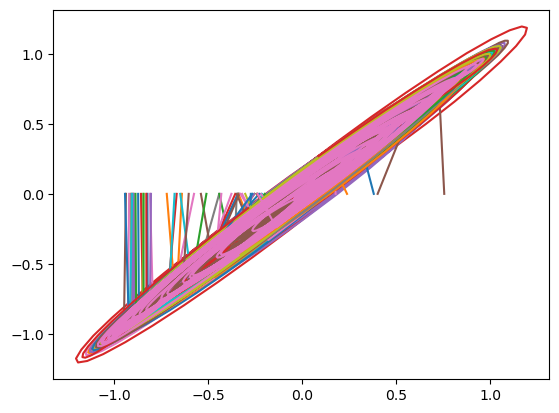

In [ ]:
plt.plot(marginal_signal.to_numpy().T[:-1, :], marginal_signal.to_numpy().T[1:, :])

In [ ]:
# pd.DataFrame.to_csv(new_df, "../data/worm_data_long.csv")

In [ ]:
# sns.lineplot(x="time_in_seconds", y="calcium_data", data=df.iloc[46507])
# sns.lineplot(x="time_in_seconds", y="calcium_data", data=df.iloc[46506])
# sns.lineplot(x="time_in_seconds", y="calcium_data", data=df.iloc[46505])